In [1]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns # for data visualization 
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras import losses, optimizers, backend
from PIL import Image
from tensorflow.keras.preprocessing import image
from keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

import warnings
# Suppress warnings
warnings.filterwarnings('ignore')


## Loading the data
- We use numpy load funtion to read the image file and panda's read_csv to read labels.csv
- check shape and size of data

In [2]:
# Reading image file and label file
images = np.load('images.npy')
labels = pd.read_csv('./Labels.csv') 

In [3]:
images.shape

(4750, 128, 128, 3)

In [4]:
labels.size

4750

The datasets contains 4750 images with 128*128 sizes with RGB values. Each image has a label with it's specie name in labels dataframe.

## Data Exploration and Summary

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64


Text(0.5, 0, 'Plant Species')

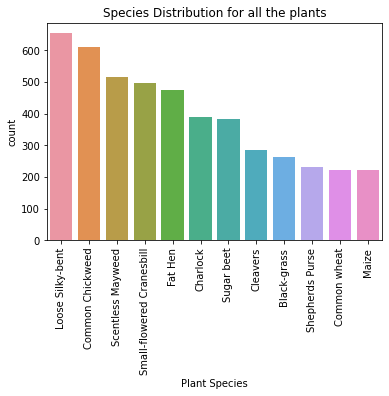

In [5]:
tb = labels['Label'].value_counts()
print(tb)
g=sns.countplot(labels['Label'], order=tb.index)
plt.xticks(rotation=90)
plt.title('Species Distribution for all the plants')
plt.xlabel('Plant Species')


# Viewing Images
- Since the image is currently one-dimension, we load it into a numpy array and reshape it so that it is two-dimensional (128x128 pixels)
- plotting few of the images with their labels using matplotlib

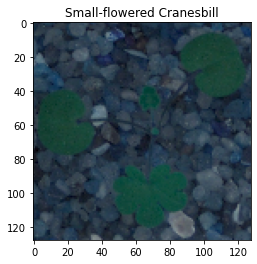

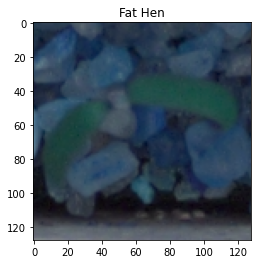

In [6]:
i=1
img = images[i]
plt.imshow(img, cmap='gray')
plt.title(labels['Label'][i])
plt.show()

i=600
img = images[i]
plt.imshow(img, cmap='gray')
plt.title(labels['Label'][i])
plt.show()



## Data Pre-processing

#### Applying Gaussian Blurring to all the images

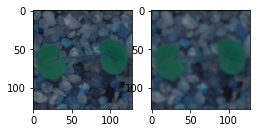

 Blurred Image


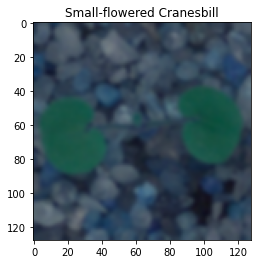

In [7]:

new_train = []
sets = []; getEx = True
for i in images:
    blurr = cv2.GaussianBlur(i,(5,5),0)  
    new_train.append(blurr)              
    if getEx:
      plt.subplot(2,3,1);plt.imshow(i)
      plt.subplot(2,3,2);plt.imshow(blurr)
      plt.show()
      getEx = False
new_train = np.asarray(new_train)
print(" Blurred Image")
#for i in range(4):
plt.imshow(new_train[0]) 
plt.title(labels['Label'][0])
plt.show()

#### Applying Normalization to all the images

In [8]:
new_train= new_train/255.0

#### Train Test Split of the dataset

In [9]:
# Data split into 75% into train and 25% into test
X_train, X_test, y_train, y_test = train_test_split(new_train,labels['Label'] , 
                                                    test_size=0.20,
                                                    random_state=1)

In [10]:
y_train[0:5]

1791    Common Chickweed
4572    Loose Silky-bent
1444    Common Chickweed
3523          Sugar beet
943              Fat Hen
Name: Label, dtype: object

## Making Data Compatible for Modeling

#### Encoding Target Variable

In [11]:
# Storing the LabelBinarizer function in lb variable
lb = LabelBinarizer() 

# Applying fit_transform on train target variable
y_train = lb.fit_transform(y_train)

# Applying only transform on test target variable
y_test = lb.transform(y_test)

In [12]:
y_train[0:5]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [13]:
X_train.shape

(3800, 128, 128, 3)

In [14]:
y_train.shape

(3800, 12)

In [15]:
X_test.shape

(950, 128, 128, 3)

In [16]:
y_test.shape

(950, 12)

## Model Building - CNN

**Model 1:**

**Build a Sequential CNN classifier with input shape as 128X128 and using three sets of Convoltutional + Pooling layers. I've used Dropout in the fully connected layers while making sure the final layer shape matches with the number of classes**

In [17]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)


# Initialising the CNN classifier
classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 64, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))

# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 32, activation = 'relu'))


# The final output layer with 10 neurons to predict the categorical classifcation
classifier.add(Dense(units = 12, activation = 'softmax'))

In [18]:
# Model summary before building
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8388672   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3

**Compiling the CNN classifier with Adam optimizer (adjusted Learning rate and other parameters)
and Categorical Crossentropy as loss function and Accuracy as the metric to monitor**

In [19]:
''' Compile model (using the efficient Adam gradient descent optimization algorithm
    with a logarithmic loss function, which is called “categorical_crossentropy” in Keras.)'''

Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
#create callback for saving checkpoint for best model

filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=3)

callbacks = [checkpoint, es_cb]

In [21]:
# Running the model on 10 epochs with 20% validation set
history=classifier.fit(x = X_train, 
                       y = y_train, 
                       batch_size = 32,
                       callbacks=callbacks,
                       epochs = 20, 
                       validation_split = 0.2)

Epoch 1/20
95/95 [==============================] - 14s 141ms/step - loss: 2.5684 - accuracy: 0.1016 - val_loss: 2.3831 - val_accuracy: 0.1382

Epoch 00001: val_loss improved from inf to 2.38305, saving model to my_best_model.hdf5
Epoch 2/20
95/95 [==============================] - 15s 152ms/step - loss: 2.3879 - accuracy: 0.1566 - val_loss: 2.2778 - val_accuracy: 0.3303

Epoch 00002: val_loss improved from 2.38305 to 2.27785, saving model to my_best_model.hdf5
Epoch 3/20
95/95 [==============================] - 14s 146ms/step - loss: 2.3106 - accuracy: 0.2227 - val_loss: 2.1619 - val_accuracy: 0.3526

Epoch 00003: val_loss improved from 2.27785 to 2.16195, saving model to my_best_model.hdf5
Epoch 4/20
95/95 [==============================] - 17s 182ms/step - loss: 2.2365 - accuracy: 0.2434 - val_loss: 2.0942 - val_accuracy: 0.3855

Epoch 00004: val_loss improved from 2.16195 to 2.09420, saving model to my_best_model.hdf5
Epoch 5/20
95/95 [==============================] - 17s 183ms/st

30/30 [==============================] - 1s 42ms/step - loss: 1.5294 - accuracy: 0.4653


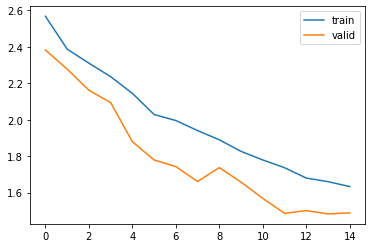

In [22]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
classifier = load_model(filepath)
results = classifier.evaluate(X_test, y_test)
y_pred = classifier.predict(X_test)

In [23]:
# Converting probabilities into label values
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [24]:
# Accuracy as per the classification report 
print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

=== Confusion Matrix ===
[[  0   0   0   0   0   1  67   0   0   0   0   3]
 [  0  35   0   0   0   5   0   0   5   0  17   4]
 [  0  20   5   0   0  22   0   0   6   0   1   1]
 [  0   2   0  78   0   3   0   0  32   0   0   1]
 [  0   0   0   0   0  10  31   0   2   0   0   1]
 [  0   6   1   2   0  47  21   0   9   0   1   4]
 [  0   0   0   0   0   3 120   0   0   0   0   2]
 [  0   1   0  13   0   0   1   4  18   0   1   1]
 [  0   7   0   3   0  11  10   0  55   0   0  14]
 [  0  13   1  17   0   5   0   0  14   1   1   0]
 [  0  32   0   2   0   4   0   0   4   0  62   3]
 [  0   5   0   0   0  21  12   0  10   0   1  35]]


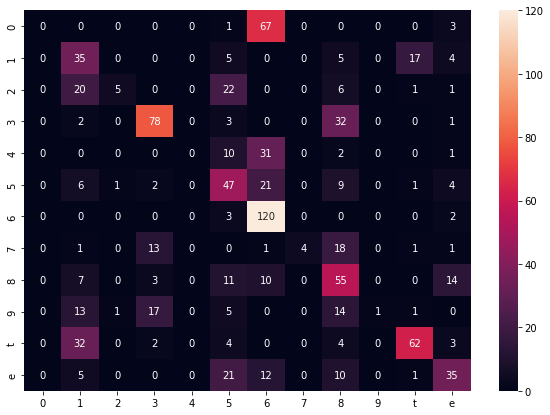

In [25]:
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789te"],
                     columns = [i for i in "0123456789te"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

In [26]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.29      0.53      0.37        66
           2       0.71      0.09      0.16        55
           3       0.68      0.67      0.68       116
           4       0.00      0.00      0.00        44
           5       0.36      0.52      0.42        91
           6       0.46      0.96      0.62       125
           7       1.00      0.10      0.19        39
           8       0.35      0.55      0.43       100
           9       1.00      0.02      0.04        52
          10       0.74      0.58      0.65       107
          11       0.51      0.42      0.46        84

    accuracy                           0.47       950
   macro avg       0.51      0.37      0.33       950
weighted avg       0.50      0.47      0.41       950



**Insight**

The model performed poorly with an accuracy score of 0.47 on the test set and and 0.41 weighted f1-score. During the test classification, model performed well with all plant species except for classes 0, 4, 7 and 9.

The model architecture was simple for such complex dataset, so underfitting is the issue for model 1.

**The performance of the model can be improved by upgrading the architecture of the CNN model. The model have 2 convolution layer and more complex ANN layers. Pooling had been performed twice after each conv layer.**

### Model 2 - Complex architecture

In [27]:
# Initialising the CNN classifier
classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 256, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))

# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))

# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 64, activation = 'relu'))

# The final output layer with 10 neurons to predict the categorical classifcation
classifier.add(Dense(units = 12, activation = 'softmax'))


In [28]:
# Model summary
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [29]:
''' Compiling model (using the efficient Adam gradient descent optimization algorithm
    with a logarithmic loss function, which is called “categorical_crossentropy” in Keras.)'''

Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
#create callback for saving checkpoint for best model

filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
es_cb = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=3)

callbacks = [checkpoint, es_cb]

In [31]:
# Model training for 20 epochs with stopping criteria 
history=classifier.fit(x = X_train, 
                       y = y_train, 
                       batch_size = 32,
                       epochs = 20, 
                       callbacks=callbacks,
                       validation_split = 0.2)

Epoch 1/20
95/95 [==============================] - 26s 270ms/step - loss: 2.4526 - accuracy: 0.1178 - val_loss: 2.4058 - val_accuracy: 0.1382

Epoch 00001: val_loss improved from inf to 2.40582, saving model to my_best_model.hdf5
Epoch 2/20
95/95 [==============================] - 25s 268ms/step - loss: 2.3932 - accuracy: 0.1526 - val_loss: 2.1112 - val_accuracy: 0.2829

Epoch 00002: val_loss improved from 2.40582 to 2.11115, saving model to my_best_model.hdf5
Epoch 3/20
95/95 [==============================] - 25s 264ms/step - loss: 2.0440 - accuracy: 0.2868 - val_loss: 1.6595 - val_accuracy: 0.4329

Epoch 00003: val_loss improved from 2.11115 to 1.65951, saving model to my_best_model.hdf5
Epoch 4/20
95/95 [==============================] - 25s 264ms/step - loss: 1.7767 - accuracy: 0.3730 - val_loss: 1.5069 - val_accuracy: 0.4842

Epoch 00004: val_loss improved from 1.65951 to 1.50695, saving model to my_best_model.hdf5
Epoch 5/20
95/95 [==============================] - 26s 273ms/st

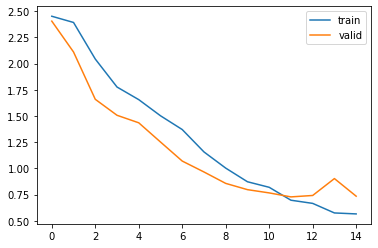

In [35]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
classifier = load_model(filepath)
#results = classifier.evaluate(X_test, y_test)
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [41]:
#Accuracy as per the classification report 
from sklearn.metrics import classification_report, confusion_matrix
print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

=== Confusion Matrix ===
[[  0   0   0   0   4   3  58   0   4   0   0   2]
 [  0  56   3   0   0   1   0   0   3   2   0   1]
 [  0   9  34   0   0   0   0   0  11   1   0   0]
 [  0   0   0 106   0   1   0   4   1   2   2   0]
 [  0   0   0   1  19   3  15   0   5   0   0   1]
 [  0   1   3   4   2  70   2   0   5   3   0   1]
 [  0   0   0   0   3   4 115   0   3   0   0   0]
 [  0   1   0   3   1   2   0  24   5   0   1   2]
 [  0   2   1   1   0   3   1   1  82   2   0   7]
 [  0   2   1   6   0   0   0   0  12  29   2   0]
 [  0   1   0   0   0   0   0   2   3   2  97   2]
 [  0   4   0   2   0   3   0   2   7   1   3  62]]


In [43]:
#Accuracy as per the classification report 
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.74      0.85      0.79        66
           2       0.81      0.62      0.70        55
           3       0.86      0.91      0.89       116
           4       0.66      0.43      0.52        44
           5       0.78      0.77      0.77        91
           6       0.60      0.92      0.73       125
           7       0.73      0.62      0.67        39
           8       0.58      0.82      0.68       100
           9       0.69      0.56      0.62        52
          10       0.92      0.91      0.92       107
          11       0.79      0.74      0.77        84

    accuracy                           0.73       950
   macro avg       0.68      0.68      0.67       950
weighted avg       0.69      0.73      0.70       950



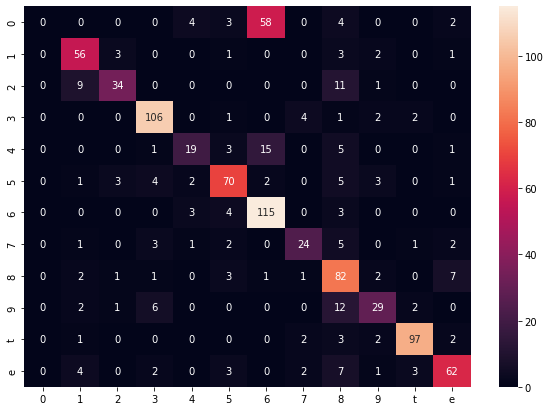

In [44]:
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789te"],
                     columns = [i for i in "0123456789te"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

In [45]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.74      0.85      0.79        66
           2       0.81      0.62      0.70        55
           3       0.86      0.91      0.89       116
           4       0.66      0.43      0.52        44
           5       0.78      0.77      0.77        91
           6       0.60      0.92      0.73       125
           7       0.73      0.62      0.67        39
           8       0.58      0.82      0.68       100
           9       0.69      0.56      0.62        52
          10       0.92      0.91      0.92       107
          11       0.79      0.74      0.77        84

    accuracy                           0.73       950
   macro avg       0.68      0.68      0.67       950
weighted avg       0.69      0.73      0.70       950



**Insight**

The model performed poorly with an accuracy score of 0.73 on the test set and and 0.70 weighted f1-score. During the test classification, model performed well with all plant species except for class 0.

This model 2 architecture outperformed model 1 with a lot of margin, but we can still improve the performance of the model with trying more architecture which requires a good CPU/GPU.

## Conclusion and key takeaways

1. The Convnet layer of CNN in model 2 improved the model performance by a huge margin while decreasing the total number of weights to learn by the model. The model 2 F1-score also seems to be fine, with a huge decrease in the False Negatives with a small increase in False Positives.

2. Both the models performed poorly for class 0, a deep dive can be taken into the specific class for further interogation.

3. The final model gives an accuracy score of 73% with weighted f1-score of 70%. The model 2 is performing best on class 10, 6, 3 by recalling correctly more than 90% on the test set.
